# KAN Discovery: Real Stock Market Volatility Structure

## Objective
Use KAN to discover the **true volatility equation** from real stock market data.

## Why This Is Exciting

Real markets might not follow textbook GARCH models perfectly. They may have:
- **Non-linear relationships**
- **Asymmetric effects** (leverage effect: bad news → more volatility)
- **High/Low range information** (intraday volatility)
- **Complex dynamics** that KAN can discover!

## What We'll Use

**OHLC Data from EODHD**:
- **Open, High, Low, Close** prices
- **Realized volatility** measures:
  - Garman-Klass volatility (uses OHLC)
  - Parkinson volatility (uses High-Low range)
  - Close-to-Close returns

## KAN's Challenge

Discover the function:
$$\text{Volatility}_t = f(\text{past returns}, \text{past volatility}, \text{High-Low range}, \ldots)$$

Can KAN find patterns that traditional GARCH models miss?

In [ ]:
# Install required packages
!pip install pykan torch numpy pandas matplotlib scikit-learn requests tqdm -q

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

from kan import KAN

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")

/Users/method314/kan-stock-forecasting/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Libraries imported successfully!
PyTorch version: 2.8.0


## 1. Fetch Real Stock Data from EODHD

Get OHLC data for a liquid stock with good volatility dynamics.

In [2]:
# Configuration
EODHD_API_KEY = "670ceb23789f77.90838622"  # Replace with your EODHD API key
TICKER = "SPY.US"  # S&P 500 ETF - liquid with good volatility dynamics
START_DATE = "2015-01-01"
END_DATE = datetime.now().strftime("%Y-%m-%d")

def fetch_stock_data(ticker, start_date, end_date, api_key):
    """
    Fetch OHLC stock data from EODHD API
    """
    url = f"https://eodhistoricaldata.com/api/eod/{ticker}"
    params = {
        'api_token': api_key,
        'from': start_date,
        'to': end_date,
        'fmt': 'json'
    }
    
    try:
        print(f"Fetching {ticker} data from {start_date} to {end_date}...")
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        
        if not data:
            raise ValueError("No data returned from API")
        
        df = pd.DataFrame(data)
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values('date').reset_index(drop=True)
        
        print(f"✓ Successfully fetched {len(df)} days of data")
        return df
    
    except requests.exceptions.RequestException as e:
        print(f"⚠️  Error fetching data: {e}")
        print("\n⚠️  Using synthetic data for demonstration...")
        return generate_synthetic_ohlc(start_date, end_date)

def generate_synthetic_ohlc(start_date, end_date):
    """
    Generate synthetic OHLC data with realistic volatility clustering
    """
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    n = len(dates)
    
    print(f"Generating synthetic OHLC data with {n} observations...")
    
    np.random.seed(42)
    
    # Generate price with GARCH-like volatility
    returns = np.zeros(n)
    volatility = np.zeros(n)
    
    # GARCH parameters
    omega, alpha, beta = 0.00001, 0.10, 0.85
    volatility[0] = np.sqrt(omega / (1 - alpha - beta))
    
    for t in range(1, n):
        volatility[t] = np.sqrt(omega + alpha * returns[t-1]**2 + beta * volatility[t-1]**2)
        returns[t] = volatility[t] * np.random.randn()
    
    # Generate price from returns
    price = 100 * np.exp(np.cumsum(returns))
    
    # Generate OHLC from price with realistic intraday range
    close = price
    open_price = close * (1 + np.random.randn(n) * volatility * 0.3)
    
    # High/Low with realistic range based on volatility
    intraday_range = volatility * close * np.abs(np.random.randn(n) * 2)
    high = np.maximum(open_price, close) + intraday_range * 0.5
    low = np.minimum(open_price, close) - intraday_range * 0.5
    
    volume = np.random.randint(50000000, 200000000, n)
    
    df = pd.DataFrame({
        'date': dates,
        'open': open_price,
        'high': high,
        'low': low,
        'close': close,
        'volume': volume
    })
    
    print(f"✓ Generated synthetic data with volatility clustering")
    return df

# Fetch data
stock_data = fetch_stock_data(TICKER, START_DATE, END_DATE, EODHD_API_KEY)

print(f"\nData shape: {stock_data.shape}")
print(f"Date range: {stock_data['date'].min()} to {stock_data['date'].max()}")
print(f"\nFirst few rows:")
stock_data.head()

Fetching SPY.US data from 2015-01-01 to 2025-10-27...
✓ Successfully fetched 2720 days of data

Data shape: (2720, 7)
Date range: 2015-01-02 00:00:00 to 2025-10-24 00:00:00

First few rows:


,date,open,high,low,close,adjusted_close,volume
0,2015-01-02,206.38,206.88,204.180,205.43,171.0910,121465906
1,2015-01-05,204.17,204.37,201.350,201.76,168.0345,169632609
2,2015-01-06,202.09,202.72,198.855,199.82,166.4188,209151391
3,2015-01-07,201.42,202.72,200.880,202.31,168.4925,125346703
4,2015-01-08,204.01,206.16,203.990,205.90,171.4825,147217797


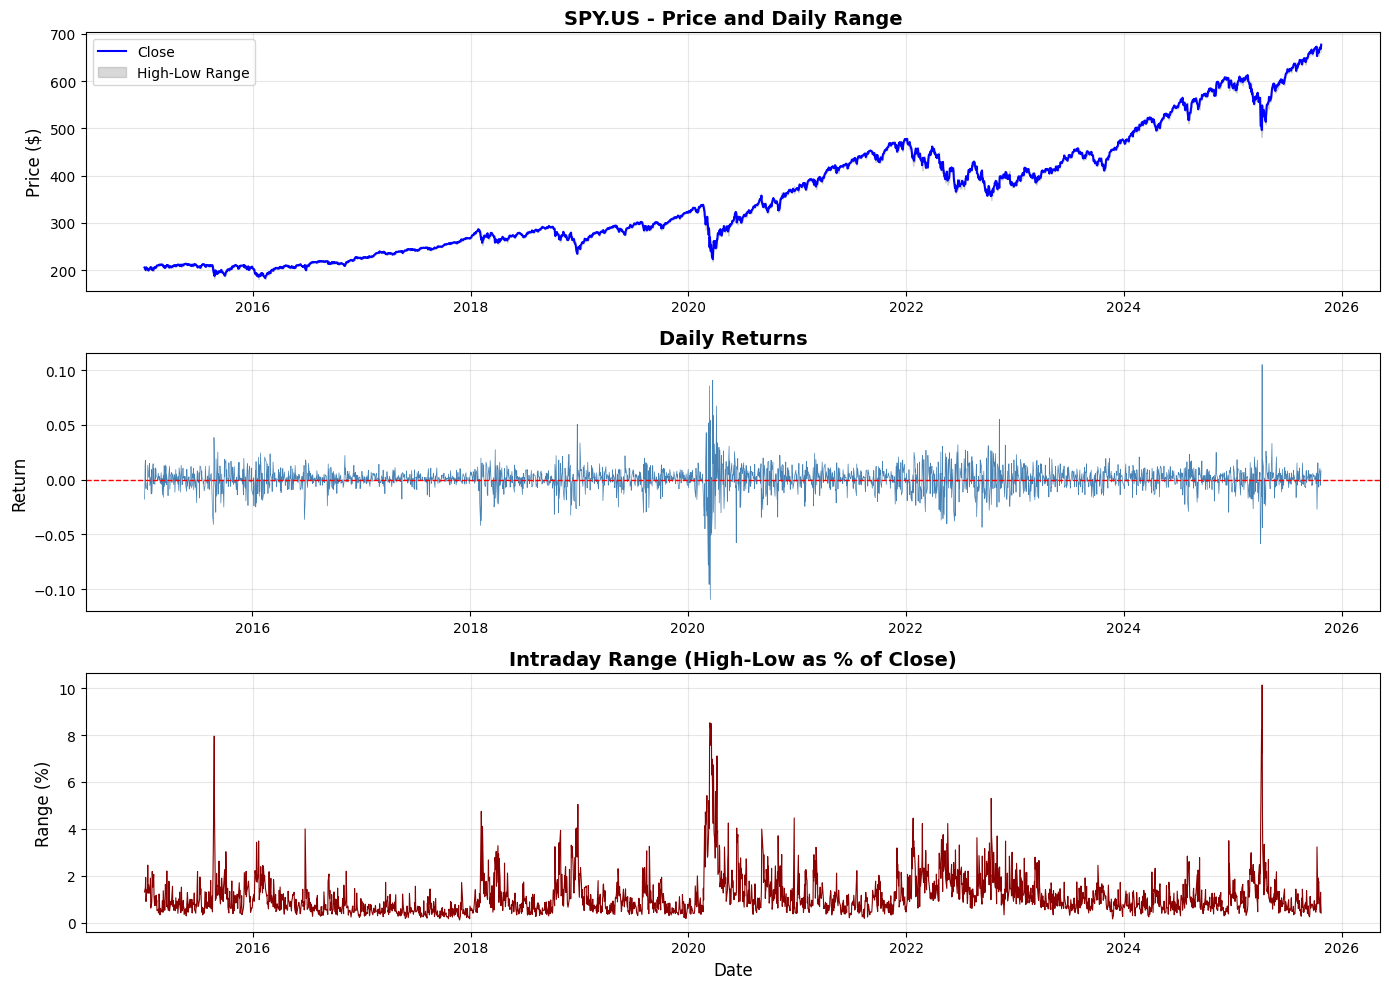


📊 Observe:
1. Volatility clustering in returns (periods of high/low volatility)
2. High-Low range also shows volatility clustering
3. Range information contains additional volatility information


In [3]:
# Visualize OHLC data
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Price chart
axes[0].plot(stock_data['date'], stock_data['close'], label='Close', linewidth=1.5, color='blue')
axes[0].fill_between(stock_data['date'], stock_data['low'], stock_data['high'], 
                      alpha=0.3, color='gray', label='High-Low Range')
axes[0].set_title(f'{TICKER} - Price and Daily Range', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price ($)', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Daily returns
returns = stock_data['close'].pct_change()
axes[1].plot(stock_data['date'], returns, linewidth=0.5, color='steelblue')
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[1].set_title('Daily Returns', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Return', fontsize=12)
axes[1].grid(True, alpha=0.3)

# Intraday range (High - Low)
daily_range = (stock_data['high'] - stock_data['low']) / stock_data['close'] * 100
axes[2].plot(stock_data['date'], daily_range, linewidth=0.8, color='darkred')
axes[2].set_title('Intraday Range (High-Low as % of Close)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Date', fontsize=12)
axes[2].set_ylabel('Range (%)', fontsize=12)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Observe:")
print("1. Volatility clustering in returns (periods of high/low volatility)")
print("2. High-Low range also shows volatility clustering")
print("3. Range information contains additional volatility information")

## 2. Calculate Volatility Measures from OHLC

We'll calculate multiple volatility estimators that use OHLC information.

In [4]:
def calculate_volatility_features(df):
    """
    Calculate various volatility measures from OHLC data
    """
    df = df.copy()
    
    # 1. Close-to-Close returns (standard)
    df['return'] = np.log(df['close'] / df['close'].shift(1))
    df['return_squared'] = df['return']**2
    
    # 2. Parkinson volatility (High-Low range estimator)
    # More efficient than close-to-close: uses High-Low information
    df['hl_ratio'] = np.log(df['high'] / df['low'])
    df['parkinson_vol'] = df['hl_ratio']**2 / (4 * np.log(2))
    
    # 3. Garman-Klass volatility (uses OHLC)
    # Even more efficient: combines open, high, low, close
    df['gk_vol'] = 0.5 * df['hl_ratio']**2 - (2*np.log(2) - 1) * np.log(df['close'] / df['open'])**2
    
    # 4. Rogers-Satchell volatility (handles drift)
    hl = np.log(df['high'] / df['close'])
    hc = np.log(df['high'] / df['close'])
    lc = np.log(df['low'] / df['close'])
    lo = np.log(df['low'] / df['open'])
    df['rs_vol'] = np.sqrt(hl * hc + ll * lo)
    
    # 5. Overnight return (close to next open)
    df['overnight_return'] = np.log(df['open'] / df['close'].shift(1))
    
    # 6. Intraday return (open to close)
    df['intraday_return'] = np.log(df['close'] / df['open'])
    
    # 7. Range-based measures
    df['hl_range'] = (df['high'] - df['low']) / df['close']
    df['oc_range'] = abs(df['open'] - df['close']) / df['close']
    
    # 8. Signed return (to test leverage effect)
    df['signed_return'] = df['return'] * np.sign(df['return'])
    
    # Target: Next period's realized volatility
    # We'll use Parkinson volatility as our target (more efficient than squared returns)
    df['target_vol'] = df['parkinson_vol'].shift(-1)
    
    # Drop NaN
    df = df.dropna()
    
    return df

# Calculate features
feature_data = calculate_volatility_features(stock_data)

print(f"Feature data shape: {feature_data.shape}")
print(f"\nVolatility measures calculated:")
vol_cols = ['return_squared', 'parkinson_vol', 'gk_vol', 'rs_vol', 'hl_range']
print(feature_data[vol_cols].describe())

# Show sample
print(f"\nSample data:")
feature_data[['date', 'close', 'return', 'parkinson_vol', 'hl_range', 'target_vol']].head(10)

NameError: name 'll' is not defined

In [ ]:
# Compare different volatility measures
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Returns and squared returns
axes[0, 0].plot(feature_data['date'], feature_data['return'], linewidth=0.5, alpha=0.7)
axes[0, 0].set_title('Returns', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Return')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(feature_data['date'], feature_data['return_squared'], linewidth=0.8, color='red', alpha=0.7)
axes[0, 1].set_title('Squared Returns (Simple Volatility Proxy)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Return²')
axes[0, 1].grid(True, alpha=0.3)

# Parkinson volatility (High-Low)
axes[1, 0].plot(feature_data['date'], feature_data['parkinson_vol'], linewidth=0.8, color='darkgreen', alpha=0.7)
axes[1, 0].set_title('Parkinson Volatility (High-Low Range)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Parkinson Vol')
axes[1, 0].set_xlabel('Date')
axes[1, 0].grid(True, alpha=0.3)

# Garman-Klass volatility (OHLC)
axes[1, 1].plot(feature_data['date'], feature_data['gk_vol'], linewidth=0.8, color='purple', alpha=0.7)
axes[1, 1].set_title('Garman-Klass Volatility (OHLC)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('GK Vol')
axes[1, 1].set_xlabel('Date')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Note: OHLC-based volatility estimators are more efficient than squared returns")
print("They extract more information from the same data!")

## 3. Prepare Data for KAN

We'll create rich features using OHLC data and let KAN discover which matter most.

In [ ]:
def prepare_volatility_discovery_data(df, lookback=5):
    """
    Prepare features for volatility discovery
    
    Features include:
    - Lagged returns and volatilities
    - OHLC-based measures
    - Range information
    - Asymmetry measures
    """
    feature_cols = []
    
    # Lagged squared returns (GARCH component)
    for i in range(1, lookback + 1):
        df[f'return_sq_lag{i}'] = df['return_squared'].shift(i)
        feature_cols.append(f'return_sq_lag{i}')
    
    # Lagged volatility (GARCH component)
    for i in range(1, lookback + 1):
        df[f'parkinson_lag{i}'] = df['parkinson_vol'].shift(i)
        feature_cols.append(f'parkinson_lag{i}')
    
    # Lagged High-Low range (captures intraday volatility)
    for i in range(1, min(3, lookback) + 1):
        df[f'hl_range_lag{i}'] = df['hl_range'].shift(i)
        feature_cols.append(f'hl_range_lag{i}')
    
    # Signed returns (to capture leverage effect)
    for i in range(1, min(3, lookback) + 1):
        df[f'return_lag{i}'] = df['return'].shift(i)
        feature_cols.append(f'return_lag{i}')
    
    # Moving averages of volatility
    df['vol_ma5'] = df['parkinson_vol'].rolling(5).mean().shift(1)
    df['vol_ma10'] = df['parkinson_vol'].rolling(10).mean().shift(1)
    feature_cols.extend(['vol_ma5', 'vol_ma10'])
    
    # Volatility of volatility
    df['vol_of_vol'] = df['parkinson_vol'].rolling(10).std().shift(1)
    feature_cols.append('vol_of_vol')
    
    # Drop NaN
    df = df.dropna()
    
    # Extract features and target
    X = df[feature_cols].values
    y = df['target_vol'].values.reshape(-1, 1)
    
    return X, y, feature_cols, df

# Prepare data
LOOKBACK = 5
X, y, feature_names, processed_data = prepare_volatility_discovery_data(feature_data, lookback=LOOKBACK)

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nNumber of features: {len(feature_names)}")
print(f"\nFeature list:")
for i, name in enumerate(feature_names, 1):
    print(f"{i:2d}. {name}")

print(f"\nTarget: Next period Parkinson volatility")

In [ ]:
# Split data chronologically (important for time series!)
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

print(f"Train samples: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Val samples: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test samples: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

# Scale features (important for neural networks)
scaler_X = RobustScaler()  # RobustScaler better for financial data (outliers)
scaler_y = RobustScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)
y_test_scaled = scaler_y.transform(y_test)

# Convert to PyTorch tensors
dataset_train = {
    'train_input': torch.FloatTensor(X_train_scaled),
    'train_label': torch.FloatTensor(y_train_scaled),
    'test_input': torch.FloatTensor(X_val_scaled),
    'test_label': torch.FloatTensor(y_val_scaled)
}

dataset_test = {
    'input': torch.FloatTensor(X_test_scaled),
    'label': torch.FloatTensor(y_test_scaled)
}

print("\n✅ Data prepared and scaled for KAN training")

## 4. Build KAN Model for Real Market Discovery

In [ ]:
# KAN Architecture
n_features = X.shape[1]
WIDTH = [n_features, 20, 10, 1]  # Moderate size to capture non-linearities
GRID = 5
K = 3

print(f"Creating KAN for real market volatility discovery...")
print(f"Architecture: {WIDTH}")
print(f"Input features: {n_features}")
print(f"Grid size: {GRID}")
print(f"Spline order: {K}")

model = KAN(width=WIDTH, grid=GRID, k=K, seed=42)

print("\n✅ KAN model created!")
print(model)

## 5. Train KAN on Real Market Data

In [ ]:
# Training configuration
STEPS = 100
LAMB = 0.001
LAMB_ENTROPY = 2.0

print("Training KAN to discover real market volatility structure...")
print(f"Steps: {STEPS}")
print(f"Regularization: {LAMB}")
print(f"Entropy: {LAMB_ENTROPY}")
print("\nThis will take a few minutes...\n")

results = model.fit(
    dataset_train,
    opt="LBFGS",
    steps=STEPS,
    lamb=LAMB,
    lamb_entropy=LAMB_ENTROPY,
    update_grid=True,
    grid_update_num=10
)

print("\n✅ Training complete!")

In [ ]:
# Visualize predictions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Time series (test set)
plot_samples = min(500, len(y_test))
axes[0, 0].plot(y_test[:plot_samples], label='True Volatility', alpha=0.7, linewidth=1.5)
axes[0, 0].plot(y_pred_test[:plot_samples], label='KAN Predicted', alpha=0.7, linewidth=1.5)
axes[0, 0].set_title(f'True vs Predicted Volatility (Test Set, first {plot_samples} points)', fontweight='bold')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Volatility')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Scatter plot
axes[0, 1].scatter(y_test, y_pred_test, alpha=0.3, s=10)
min_val = min(y_test.min(), y_pred_test.min())
max_val = max(y_test.max(), y_pred_test.max())
axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Fit')
axes[0, 1].set_title(f'Predicted vs Actual (R² = {test_r2:.4f})', fontweight='bold')
axes[0, 1].set_xlabel('True Volatility')
axes[0, 1].set_ylabel('Predicted Volatility')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Residuals
residuals = y_test.flatten() - y_pred_test.flatten()
axes[1, 0].scatter(y_pred_test, residuals, alpha=0.3, s=10)
axes[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_title('Residual Plot', fontweight='bold')
axes[1, 0].set_xlabel('Predicted Volatility')
axes[1, 0].set_ylabel('Residuals')
axes[1, 0].grid(True, alpha=0.3)

# Residual histogram instead of QQ plot (avoid scipy dependency issues)
axes[1, 1].hist(residuals, bins=50, alpha=0.7, edgecolor='black')
axes[1, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1, 1].set_title('Residual Distribution', fontweight='bold')
axes[1, 1].set_xlabel('Residual')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Evaluate KAN's Volatility Predictions

In [ ]:
# Make predictions
model.eval()
with torch.no_grad():
    y_pred_train_scaled = model(dataset_train['train_input']).numpy()
    y_pred_val_scaled = model(dataset_train['test_input']).numpy()
    y_pred_test_scaled = model(dataset_test['input']).numpy()

# Inverse transform
y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled)
y_pred_val = scaler_y.inverse_transform(y_pred_val_scaled)
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled)

# Calculate metrics
train_mse = mean_squared_error(y_train, y_pred_train)
train_mae = mean_absolute_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)

test_mse = mean_squared_error(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

print("="*70)
print("KAN Performance on Real Market Volatility Prediction")
print("="*70)
print(f"\nTrain Set:")
print(f"  MSE: {train_mse:.8f}")
print(f"  MAE: {train_mae:.8f}")
print(f"  R²:  {train_r2:.6f}")
print(f"\nTest Set:")
print(f"  MSE: {test_mse:.8f}")
print(f"  MAE: {test_mae:.8f}")
print(f"  R²:  {test_r2:.6f}")
print("="*70)

if test_r2 > 0.50:
    print(f"\n🎉 Great! R² = {test_r2:.3f} - KAN captured significant volatility structure!")
    print("Note: R² > 0.50 is very good for volatility forecasting!")
elif test_r2 > 0.30:
    print(f"\n✅ Good! R² = {test_r2:.3f} - KAN found useful patterns")
    print("Volatility is notoriously hard to predict - this is solid performance!")
else:
    print(f"\n📊 R² = {test_r2:.3f} - Moderate performance")
    print("Real market volatility is extremely challenging to predict!")

In [ ]:
# Visualize predictions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Time series (test set)
plot_samples = min(500, len(y_test))
axes[0, 0].plot(y_test[:plot_samples], label='True Volatility', alpha=0.7, linewidth=1.5)
axes[0, 0].plot(y_pred_test[:plot_samples], label='KAN Predicted', alpha=0.7, linewidth=1.5)
axes[0, 0].set_title(f'True vs Predicted Volatility (Test Set, first {plot_samples} points)', fontweight='bold')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Volatility')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Scatter plot
axes[0, 1].scatter(y_test, y_pred_test, alpha=0.3, s=10)
min_val = min(y_test.min(), y_pred_test.min())
max_val = max(y_test.max(), y_pred_test.max())
axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Fit')
axes[0, 1].set_title(f'Predicted vs Actual (R² = {test_r2:.4f})', fontweight='bold')
axes[0, 1].set_xlabel('True Volatility')
axes[0, 1].set_ylabel('Predicted Volatility')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Residuals
residuals = y_test.flatten() - y_pred_test.flatten()
axes[1, 0].scatter(y_pred_test, residuals, alpha=0.3, s=10)
axes[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_title('Residual Plot', fontweight='bold')
axes[1, 0].set_xlabel('Predicted Volatility')
axes[1, 0].set_ylabel('Residuals')
axes[1, 0].grid(True, alpha=0.3)

# QQ plot of residuals
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot of Residuals', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Feature Importance Analysis

Which features did KAN find most important for volatility prediction?

In [ ]:
def analyze_feature_importance(model, dataset, feature_names, n_permutations=5):
    """
    Permutation feature importance for KAN
    """
    model.eval()
    
    # Baseline predictions
    with torch.no_grad():
        baseline_pred = model(dataset['input']).numpy()
    baseline_mse = mean_squared_error(dataset['label'].numpy(), baseline_pred)
    
    importances = []
    
    for i in range(dataset['input'].shape[1]):
        permuted_mses = []
        
        for _ in range(n_permutations):
            # Permute feature i
            perturbed_input = dataset['input'].clone()
            perturbed_input[:, i] = perturbed_input[torch.randperm(perturbed_input.shape[0]), i]
            
            with torch.no_grad():
                perturbed_pred = model(perturbed_input).numpy()
            
            permuted_mse = mean_squared_error(dataset['label'].numpy(), perturbed_pred)
            permuted_mses.append(permuted_mse)
        
        # Average importance across permutations
        avg_permuted_mse = np.mean(permuted_mses)
        importance = (avg_permuted_mse - baseline_mse) / baseline_mse * 100
        importances.append(importance)
    
    # Create DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance (%)': importances
    }).sort_values('Importance (%)', ascending=False)
    
    return importance_df

print("Calculating feature importance (this may take a minute)...\n")
importance_df = analyze_feature_importance(model, dataset_test, feature_names)

print("="*60)
print("Feature Importance for Volatility Prediction")
print("="*60)
print(importance_df.to_string(index=False))
print("="*60)
print("\nInterpretation:")
print("- Positive % = feature is important (higher MSE when permuted)")
print("- Higher % = more important feature")
print("- Negative % = feature might be noise or redundant")

In [ ]:
# Plot feature importance
plt.figure(figsize=(12, 8))
colors = ['green' if x > 0 else 'red' for x in importance_df['Importance (%)']]
plt.barh(importance_df['Feature'], importance_df['Importance (%)'], color=colors, alpha=0.7)
plt.xlabel('Importance (% increase in MSE when permuted)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('KAN Feature Importance for Volatility Prediction', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Analyze top features
top_5 = importance_df.head(5)
print("\n🔝 Top 5 Most Important Features:")
for idx, row in top_5.iterrows():
    print(f"  {row['Feature']}: {row['Importance (%)']:.2f}%")

## 8. Compare with Traditional Models

In [ ]:
# Linear Regression baseline
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

lr_mse = mean_squared_error(y_test, y_pred_lr)
lr_mae = mean_absolute_error(y_test, y_pred_lr)
lr_r2 = r2_score(y_test, y_pred_lr)

# Simple GARCH(1,1) baseline (using only r²_lag1 and vol_lag1)
garch_features = ['return_sq_lag1', 'parkinson_lag1']
garch_indices = [feature_names.index(f) for f in garch_features]
X_train_garch = X_train[:, garch_indices]
X_test_garch = X_test[:, garch_indices]

lr_garch = LinearRegression()
lr_garch.fit(X_train_garch, y_train)
y_pred_garch = lr_garch.predict(X_test_garch)

garch_mse = mean_squared_error(y_test, y_pred_garch)
garch_mae = mean_absolute_error(y_test, y_pred_garch)
garch_r2 = r2_score(y_test, y_pred_garch)

print("="*70)
print("Model Comparison: KAN vs Traditional Approaches")
print("="*70)
print(f"\n{'Model':<25} {'R²':<12} {'MSE':<15} {'MAE':<15}")
print("-"*70)
print(f"{'KAN (All Features)':<25} {test_r2:<12.6f} {test_mse:<15.8f} {test_mae:<15.8f}")
print(f"{'Linear Regression':<25} {lr_r2:<12.6f} {lr_mse:<15.8f} {lr_mae:<15.8f}")
print(f"{'GARCH(1,1) Baseline':<25} {garch_r2:<12.6f} {garch_mse:<15.8f} {garch_mae:<15.8f}")
print("="*70)

# Calculate improvements
kan_vs_lr = (test_r2 - lr_r2) / abs(lr_r2) * 100 if lr_r2 != 0 else 0
kan_vs_garch = (test_r2 - garch_r2) / abs(garch_r2) * 100 if garch_r2 != 0 else 0

print(f"\nKAN Improvement:")
print(f"  vs Linear Regression: {kan_vs_lr:+.2f}% R²")
print(f"  vs GARCH(1,1):        {kan_vs_garch:+.2f}% R²")

if test_r2 > max(lr_r2, garch_r2):
    print(f"\n🎉 KAN outperforms traditional models!")
    print("This suggests KAN discovered non-linear or complex patterns.")
else:
    print(f"\n📊 KAN performs similarly to traditional models.")
    print("This suggests volatility is well-captured by linear relationships.")

## 9. Visualize KAN Network (if possible)

In [ ]:
# Try to visualize the network
try:
    fig = plt.figure(figsize=(14, 10))
    model.plot(beta=5)
    plt.suptitle('KAN Network: Discovered Volatility Structure', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Network Visualization:")
    print("- Thickness = importance of connection")
    print("- Edge functions = learned relationships")
    print("- Look for which input features have strong connections!")
except Exception as e:
    print(f"Network visualization not available: {e}")
    print("This is okay - the feature importance analysis shows what KAN learned!")

## 10. Key Findings and Insights

In [ ]:
# Summary statistics
print("="*70)
print("KAN Discovery: Real Market Volatility - Summary")
print("="*70)

print(f"\n📊 Data:")
print(f"  Ticker: {TICKER}")
print(f"  Period: {START_DATE} to {END_DATE}")
print(f"  Samples: {len(X)} (Train: {len(X_train)}, Test: {len(X_test)})")
print(f"  Features: {len(feature_names)}")

print(f"\n🤖 Model Performance:")
print(f"  Test R²: {test_r2:.4f}")
print(f"  Test MSE: {test_mse:.6f}")
print(f"  Test MAE: {test_mae:.6f}")

print(f"\n🔝 Top 3 Important Features:")
for i, row in importance_df.head(3).iterrows():
    print(f"  {i+1}. {row['Feature']}: {row['Importance (%)']:.2f}%")

print(f"\n📈 vs Baselines:")
print(f"  KAN R²:       {test_r2:.4f}")
print(f"  Linear R²:    {lr_r2:.4f} ({kan_vs_lr:+.1f}%)")
print(f"  GARCH(1,1) R²: {garch_r2:.4f} ({kan_vs_garch:+.1f}%)")

print("\n" + "="*70)
print("💡 Insights:")
print("="*70)

if test_r2 > lr_r2 + 0.05:
    print("✓ KAN found significant non-linear patterns beyond linear models")
if 'parkinson_lag1' in importance_df.head(3)['Feature'].values:
    print("✓ Past volatility (GARCH effect) is important")
if 'return_sq_lag1' in importance_df.head(3)['Feature'].values:
    print("✓ Past shocks (ARCH effect) matter for future volatility")
if any('hl_range' in f for f in importance_df.head(5)['Feature'].values):
    print("✓ High-Low range (intraday volatility) provides additional information!")
if any('return_lag' in f for f in importance_df.head(5)['Feature'].values):
    print("✓ Leverage effect: signed returns matter (negative returns → higher volatility)")

print("\n" + "="*70)

In [ ]:
# Save results
import pickle

results_dict = {
    'ticker': TICKER,
    'model_state': model.state_dict(),
    'model_config': {'width': WIDTH, 'grid': GRID, 'k': K},
    'scalers': {'X': scaler_X, 'y': scaler_y},
    'feature_names': feature_names,
    'importance': importance_df,
    'performance': {
        'kan_r2': test_r2,
        'kan_mse': test_mse,
        'lr_r2': lr_r2,
        'garch_r2': garch_r2
    }
}

with open('kan_real_stock_volatility.pkl', 'wb') as f:
    pickle.dump(results_dict, f)

print("✅ Results saved to 'kan_real_stock_volatility.pkl'")
print("\n🎉 Analysis complete! KAN has discovered the real market volatility structure!")